## Full screen

In [1]:
# setting up the notebook width to 100% of the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Install and import libs

In [2]:
# !pip install decorator==5.0.9
!pip install torch-geometric==2.3.1

%matplotlib inline
import os
import torch
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Define helper functions

In [3]:
def visualize(data, labels):
    tsne = TSNE(n_components=2, init='pca', random_state=7)
    tsne_res = tsne.fit_transform(data)
    v = pd.DataFrame(data,columns=[str(i) for i in range(data.shape[1])])
    v['color'] = labels
    v['label'] = v['color'].apply(lambda i: str(i))
    v["dim1"] = tsne_res[:,0]
    v["dim2"] = tsne_res[:,1]
    
    plt.figure(figsize=(12,12))

    sns.scatterplot(
        x="dim1", y="dim2",
        hue="color",
        palette=sns.color_palette(["#52D1DC", "#8D0004", "#845218","#563EAA", "#E44658", "#63C100", "#FF7800"]),
        legend=False,
        data=v,
    )

In [4]:
def visualize_graph(G, color):
    plt.figure(figsize=(15,15))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

## Load graph dataset

In [5]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer')
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6


## Describe selected graph data

In [6]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


## Visualize graph

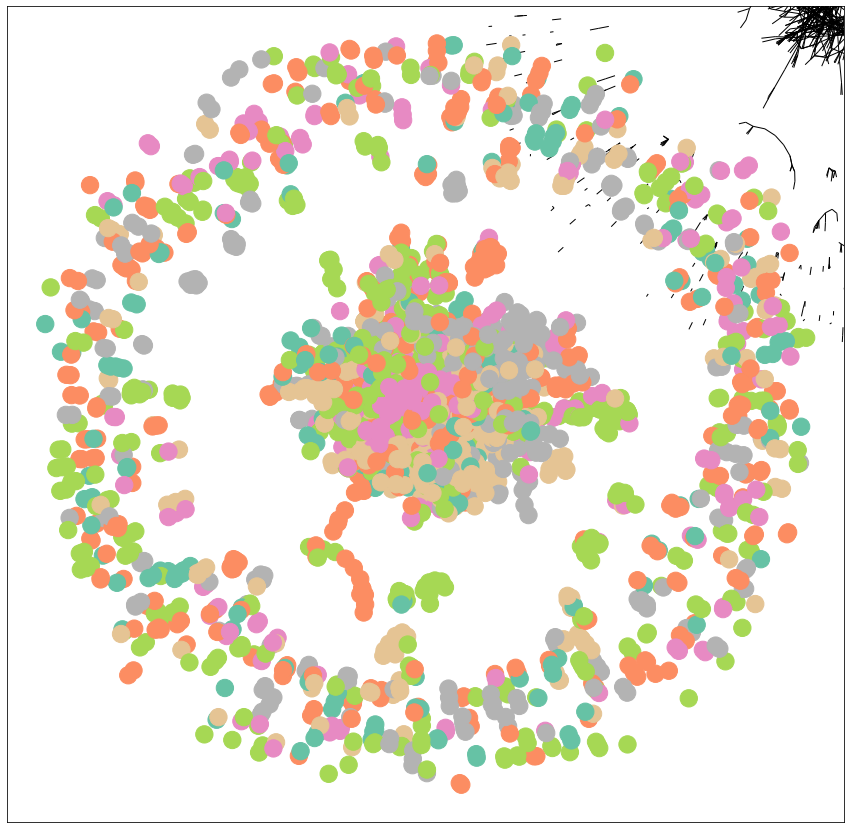

In [7]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

## Graph model 1: Classic MLP

### Define and instantiate MLP model

In [8]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=3703, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=6, bias=True)
)


### Visualize initial MLP embeddings for different graph nodes

<ipython-input-3-90be0b60c7a0>:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


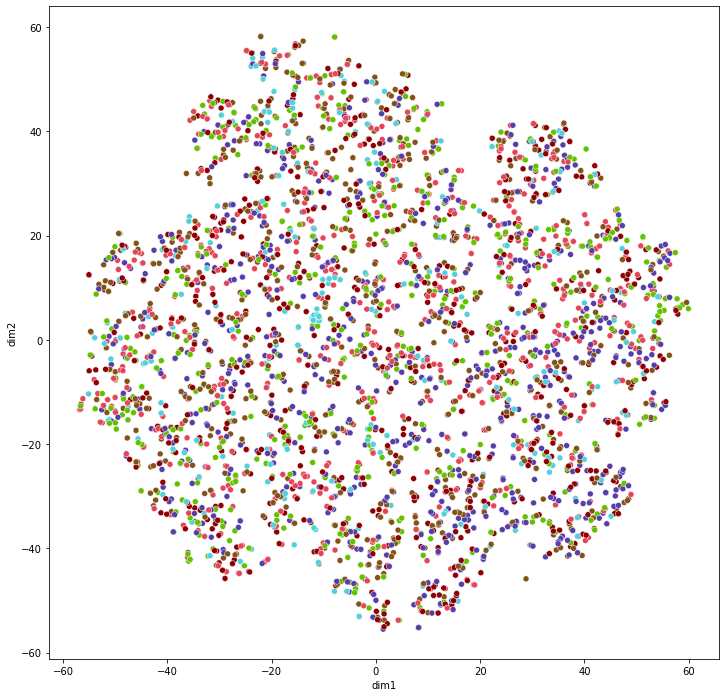

In [9]:
model.eval()
out = model(data.x)
visualize(out.detach().cpu().numpy(), data.y)

### Train MLP model on graph dataset

In [10]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.8052, Val: 0.1020
Epoch: 002, Loss: 1.7371, Val: 0.1540
Epoch: 003, Loss: 1.6468, Val: 0.1940
Epoch: 004, Loss: 1.5291, Val: 0.2820
Epoch: 005, Loss: 1.3691, Val: 0.3720
Epoch: 006, Loss: 1.2793, Val: 0.4420
Epoch: 007, Loss: 1.0911, Val: 0.4760
Epoch: 008, Loss: 0.9573, Val: 0.5120
Epoch: 009, Loss: 0.8932, Val: 0.5180
Epoch: 010, Loss: 0.7698, Val: 0.5220
Epoch: 011, Loss: 0.6757, Val: 0.5300
Epoch: 012, Loss: 0.5749, Val: 0.5240
Epoch: 013, Loss: 0.5312, Val: 0.5260
Epoch: 014, Loss: 0.4824, Val: 0.5340
Epoch: 015, Loss: 0.4760, Val: 0.5300
Epoch: 016, Loss: 0.4488, Val: 0.5320
Epoch: 017, Loss: 0.3238, Val: 0.5260
Epoch: 018, Loss: 0.3813, Val: 0.5260
Epoch: 019, Loss: 0.3356, Val: 0.5260
Epoch: 020, Loss: 0.2751, Val: 0.5260
Epoch: 021, Loss: 0.3348, Val: 0.5360
Epoch: 022, Loss: 0.2972, Val: 0.5340
Epoch: 023, Loss: 0.2597, Val: 0.5300
Epoch: 024, Loss: 0.3105, Val: 0.5300
Epoch: 025, Loss: 0.2979, Val: 0.5300
Epoch: 026, Loss: 0.2541, Val: 0.5260
Epoch: 027, 

### Evaluate model performance on test set

In [11]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5710


### Visualize trained model's embeddings for different graph nodes

<ipython-input-3-90be0b60c7a0>:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


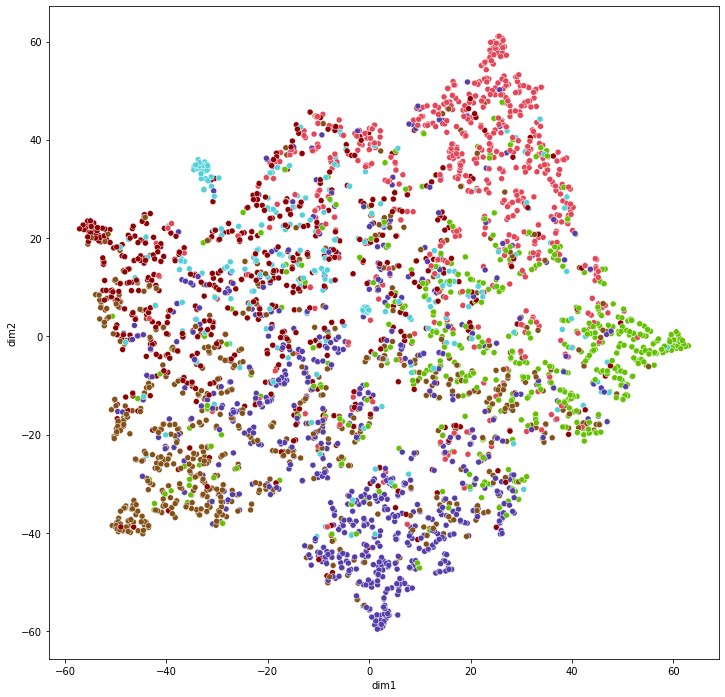

In [12]:
out = model(data.x)
visualize(out.detach().cpu().numpy(), data.y)

## Graph model 2: GCN

### Define and instantiate GCN model

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(3703, 16)
  (conv2): GCNConv(16, 6)
)


### Visualize initial GCN embeddings for different graph nodes

<ipython-input-3-90be0b60c7a0>:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


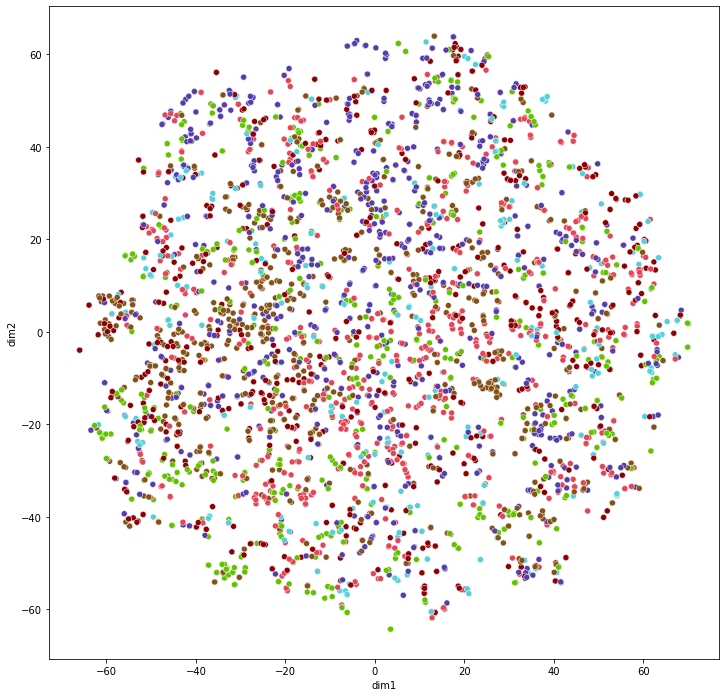

In [14]:
model = GCN(hidden_channels=32)
model.eval()

out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

### Train GCN model on graph dataset

In [15]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.7871, Val: 0.3620
Epoch: 002, Loss: 1.6260, Val: 0.4100
Epoch: 003, Loss: 1.4544, Val: 0.5100
Epoch: 004, Loss: 1.2277, Val: 0.5740
Epoch: 005, Loss: 1.0790, Val: 0.6200
Epoch: 006, Loss: 0.9047, Val: 0.6580
Epoch: 007, Loss: 0.7185, Val: 0.6840
Epoch: 008, Loss: 0.6246, Val: 0.6880
Epoch: 009, Loss: 0.5116, Val: 0.7020
Epoch: 010, Loss: 0.4641, Val: 0.7040
Epoch: 011, Loss: 0.4482, Val: 0.7060
Epoch: 012, Loss: 0.3567, Val: 0.7060
Epoch: 013, Loss: 0.2940, Val: 0.6960
Epoch: 014, Loss: 0.2789, Val: 0.6900
Epoch: 015, Loss: 0.2486, Val: 0.6880
Epoch: 016, Loss: 0.2356, Val: 0.6920
Epoch: 017, Loss: 0.2410, Val: 0.6980
Epoch: 018, Loss: 0.1904, Val: 0.6880
Epoch: 019, Loss: 0.2034, Val: 0.6880
Epoch: 020, Loss: 0.1713, Val: 0.6860
Epoch: 021, Loss: 0.1485, Val: 0.6840
Epoch: 022, Loss: 0.1872, Val: 0.6840
Epoch: 023, Loss: 0.1672, Val: 0.6880
Epoch: 024, Loss: 0.1606, Val: 0.6920
Epoch: 025, Loss: 0.1417, Val: 0.6880
Epoch: 026, Loss: 0.1766, Val: 0.6920
Epoch: 027, 

### Evaluate model performance on test set

In [16]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6960


### Visualize trained model's embeddings for different graph nodes

<ipython-input-3-90be0b60c7a0>:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


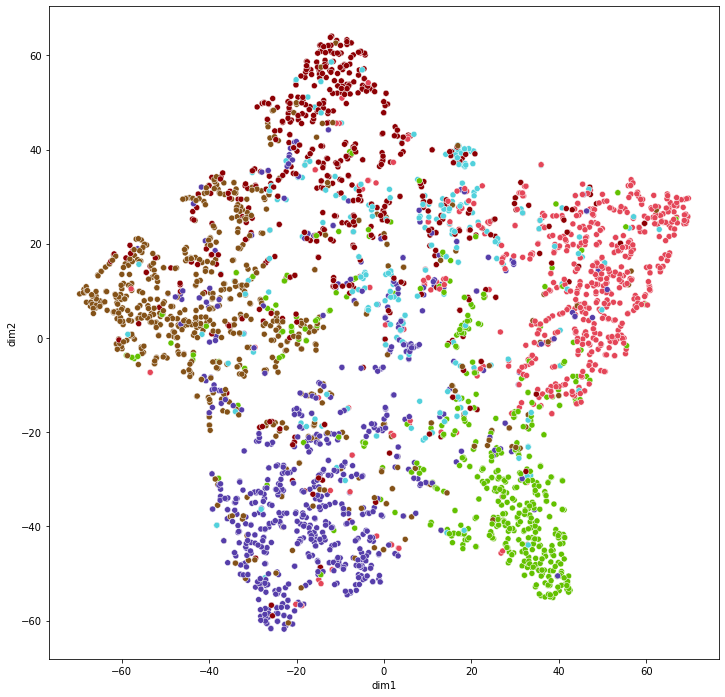

In [17]:
out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

## Graph model 3: GAT

### Define and instantiate GAT model

In [18]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16, heads=8)
print(model)

GAT(
  (conv1): GATConv(3703, 16, heads=8)
  (conv2): GATConv(128, 6, heads=1)
)


### Visualize initial GAT embeddings for different graph nodes

<ipython-input-3-90be0b60c7a0>:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


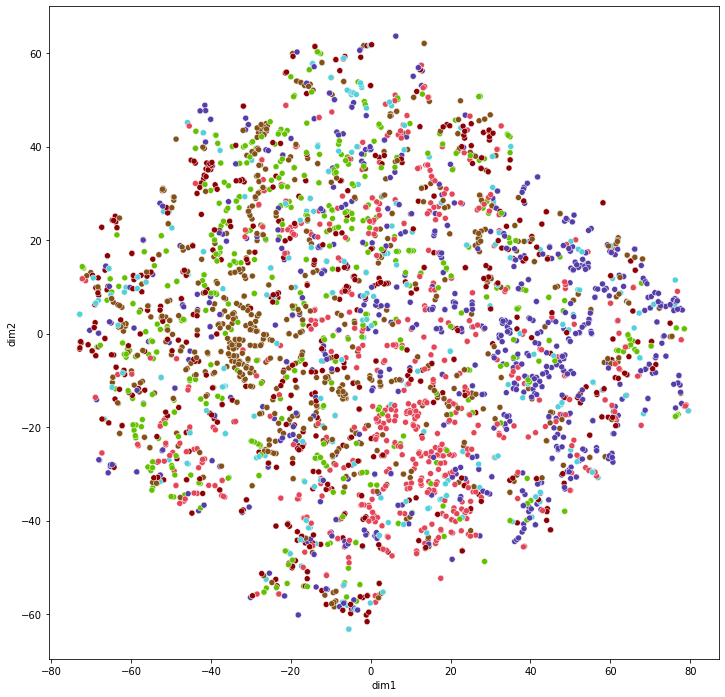

In [19]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)

### Train GAT model on graph dataset

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-1)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 101):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}')

Epoch: 001, Loss: 1.7793, Val: 0.2180
Epoch: 002, Loss: 1.7874, Val: 0.2320
Epoch: 003, Loss: 1.7888, Val: 0.2480
Epoch: 004, Loss: 1.7795, Val: 0.2760
Epoch: 005, Loss: 1.7772, Val: 0.2980
Epoch: 006, Loss: 1.7481, Val: 0.3220
Epoch: 007, Loss: 1.7355, Val: 0.3560
Epoch: 008, Loss: 1.7179, Val: 0.3980
Epoch: 009, Loss: 1.7231, Val: 0.4520
Epoch: 010, Loss: 1.7194, Val: 0.4820
Epoch: 011, Loss: 1.7055, Val: 0.5000
Epoch: 012, Loss: 1.7018, Val: 0.5200
Epoch: 013, Loss: 1.6984, Val: 0.5360
Epoch: 014, Loss: 1.6669, Val: 0.5640
Epoch: 015, Loss: 1.6698, Val: 0.5740
Epoch: 016, Loss: 1.6604, Val: 0.5880
Epoch: 017, Loss: 1.6674, Val: 0.5920
Epoch: 018, Loss: 1.6656, Val: 0.6060
Epoch: 019, Loss: 1.6460, Val: 0.6160
Epoch: 020, Loss: 1.6564, Val: 0.6280
Epoch: 021, Loss: 1.6414, Val: 0.6380
Epoch: 022, Loss: 1.6111, Val: 0.6440
Epoch: 023, Loss: 1.6215, Val: 0.6500
Epoch: 024, Loss: 1.6152, Val: 0.6560
Epoch: 025, Loss: 1.6079, Val: 0.6620
Epoch: 026, Loss: 1.5766, Val: 0.6660
Epoch: 027, 

### Evaluate model performance on test set

In [21]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7210


### Visualize trained model's embeddings for different graph nodes

<ipython-input-3-90be0b60c7a0>:12: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(


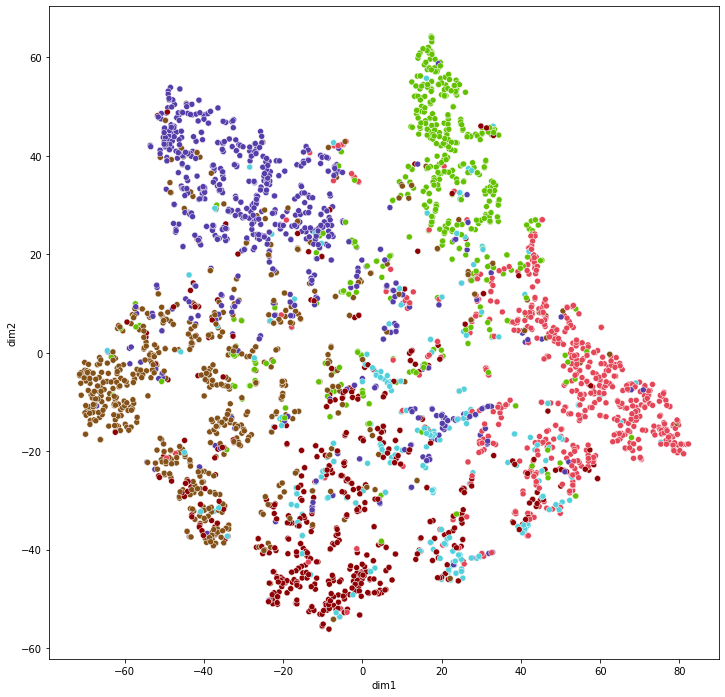

In [22]:
out = model(data.x, data.edge_index)
visualize(out.detach().cpu().numpy(), data.y)